# DeepSDF Auto-Decoder Implementation for 2D Geometric Shapes

This notebook implements an auto-decoder approach for learning a latent space of 2D geometric shapes,
inspired by the DeepSDF paper. Unlike traditional VAEs, auto-decoders directly optimize
latent codes for each shape along with the decoder network, providing more direct control
over the latent representation.

## Key Features:
- **Direct latent optimization**: No encoder network needed
- **Geometric shape generation**: Uses Signed Distance Fields (SDFs) for perfect shapes
- **Interactive visualization**: 2D latent space exploration in React web app
- **TensorFlow.js deployment**: Model runs entirely in the browser

This approach is particularly well-suited for geometric data where precise reconstruction
and interpretable latent representations are important.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import json

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Import SDF Generator and Create Minimal Dataset

We'll import our SDF generator and create a minimal dataset with just one sample per shape class.

Generated dataset: 4 shapes, (4, 28, 28)


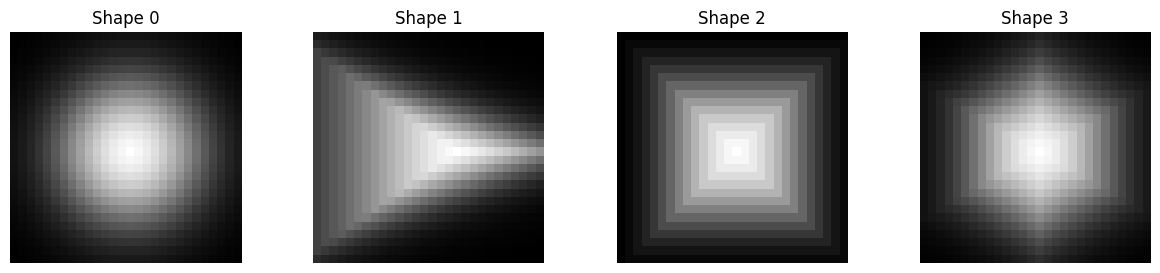

In [2]:
# Import the SDF generator
from sdf_generator import generate_sdf_dataset_sample, normalize_sdf_dataset

# Generate a minimal dataset (one sample per shape class)
x_data, y_data = generate_sdf_dataset_sample(n_samples_per_class=1)

# Normalize the SDF values
x_data = normalize_sdf_dataset(x_data, method='sigmoid')

# Flatten images
x_data_flat = x_data.reshape((len(x_data), np.prod(x_data.shape[1:])))

print(f"Generated dataset: {len(x_data)} shapes, {x_data.shape}")

# Visualize the shapes
plt.figure(figsize=(15, 3))
for i in range(len(x_data)):
    plt.subplot(1, len(x_data), i + 1)
    plt.imshow(x_data[i], cmap='gray')
    plt.title(f"Shape {y_data[i]}")
    plt.axis('off')
plt.show()

## Implement Auto-Decoder Model

The auto-decoder model consists of:
1. A set of learnable latent codes (one per shape)
2. A decoder network that maps from latent space to shape

During training, we optimize both the latent codes and the decoder parameters.

In [3]:
# Latent dimension for the model
LATENT_DIM = 2  # 2D latent space for visualization

# Number of shapes in our dataset
NUM_SHAPES = len(x_data)

# Build the decoder model
def create_decoder():
    decoder = keras.Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        
        # Dense layers to process the latent code
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        
        # Output layer that produces flattened 28x28 image
        layers.Dense(28 * 28, activation='sigmoid')
    ])
    return decoder

# Create the decoder
decoder = create_decoder()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 784)               402192    
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                        

Epoch 1/10000, Loss: 0.097015


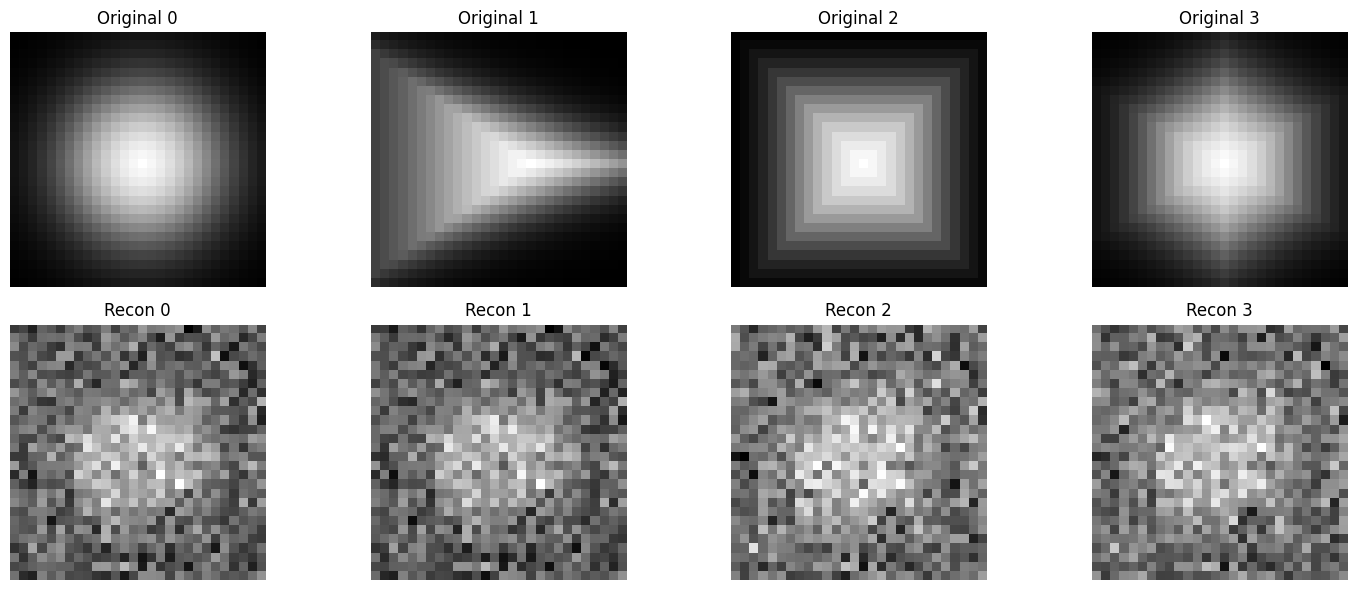

Epoch 1000/10000, Loss: 0.000033


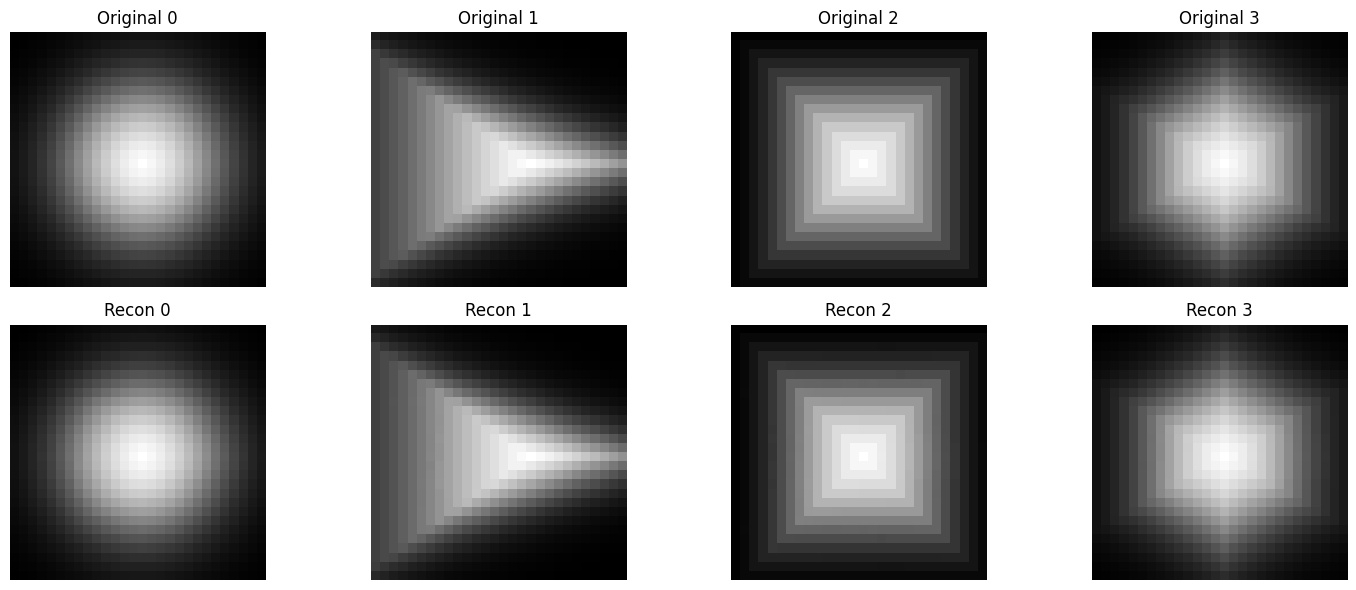

Epoch 2000/10000, Loss: 0.000000


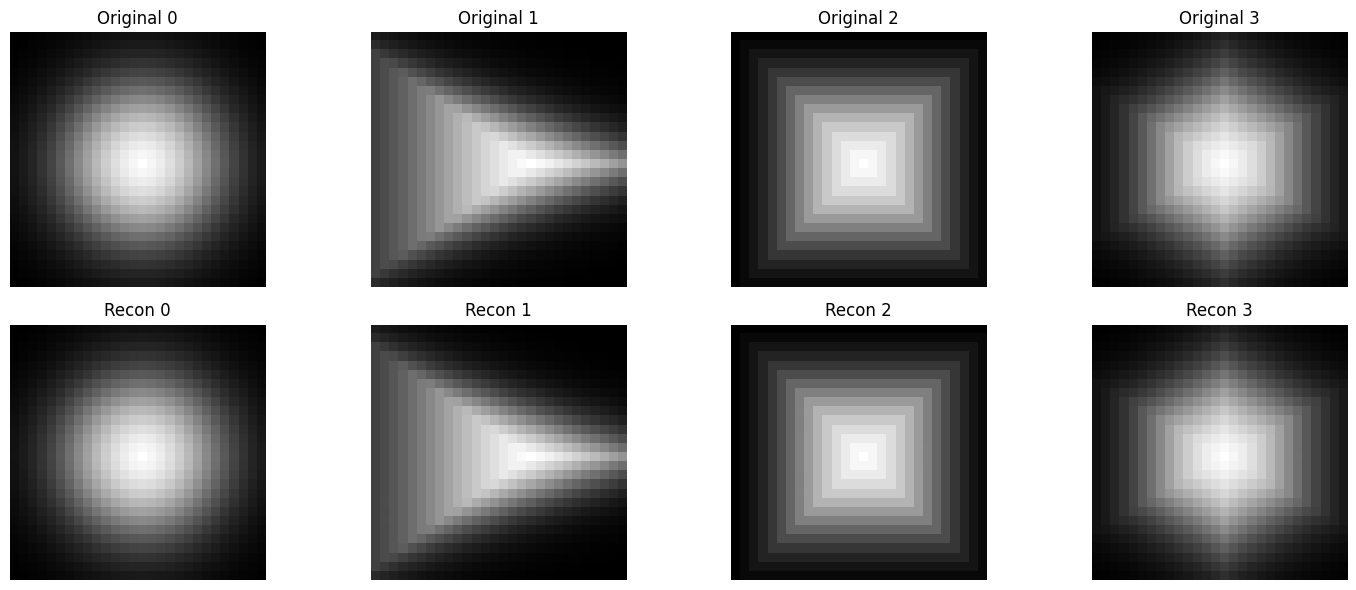

Epoch 3000/10000, Loss: 0.000000


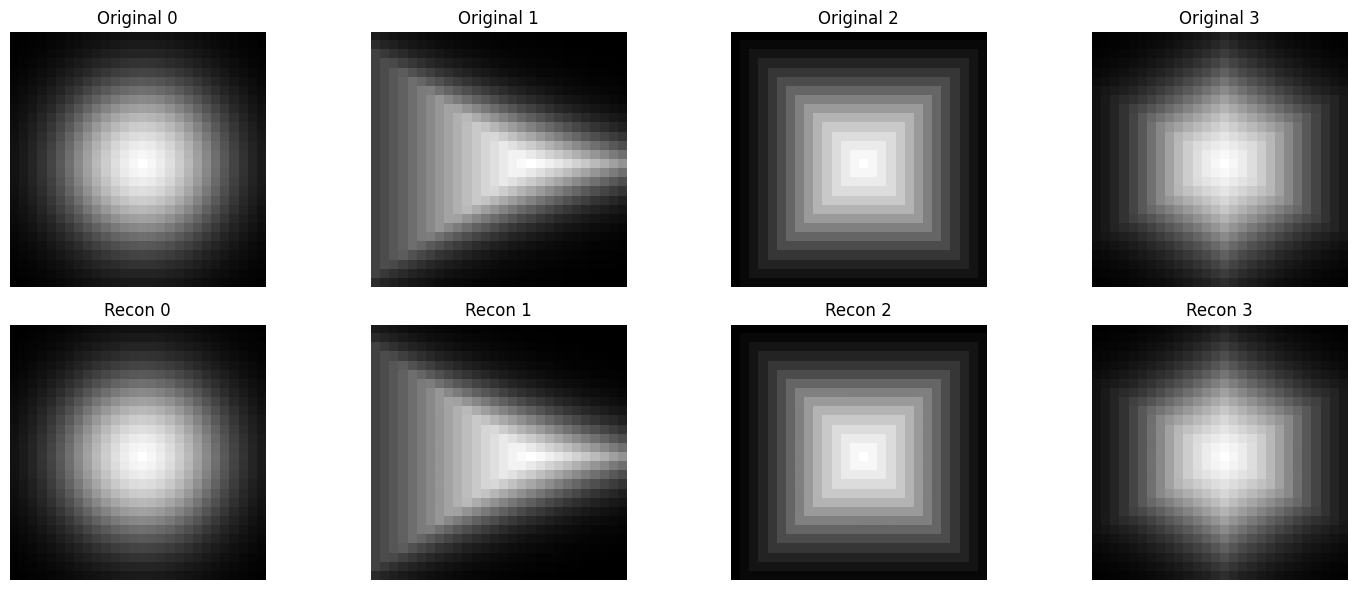

Epoch 4000/10000, Loss: 0.000000


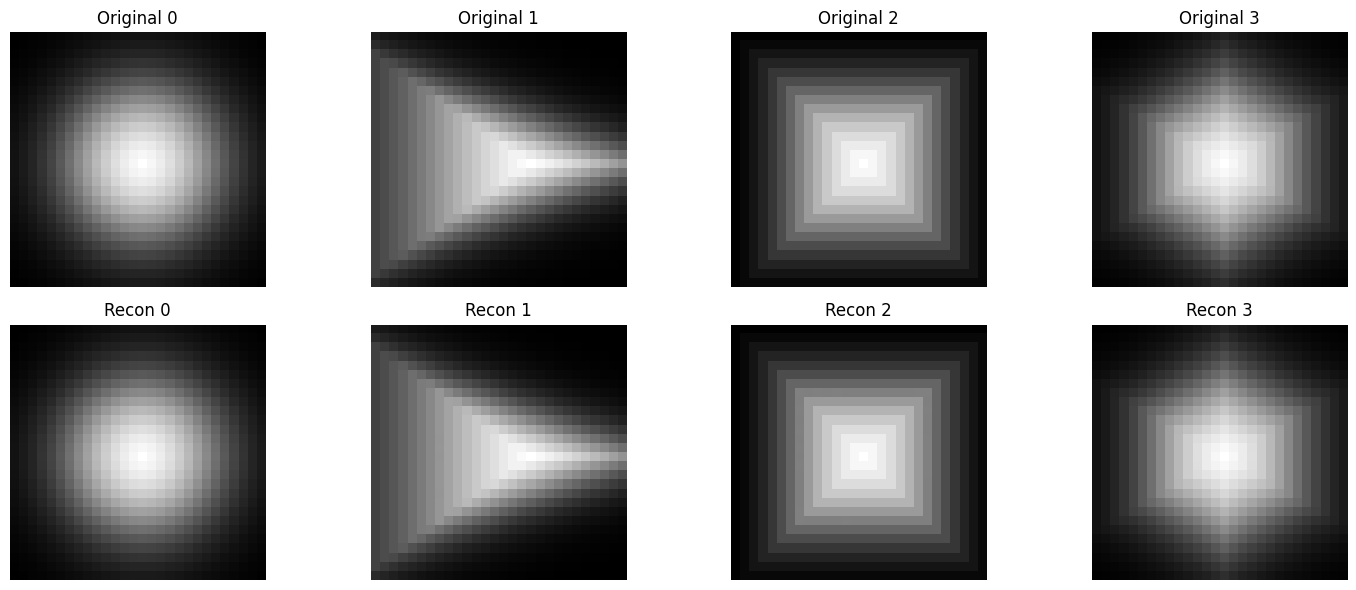

Epoch 5000/10000, Loss: 0.000000


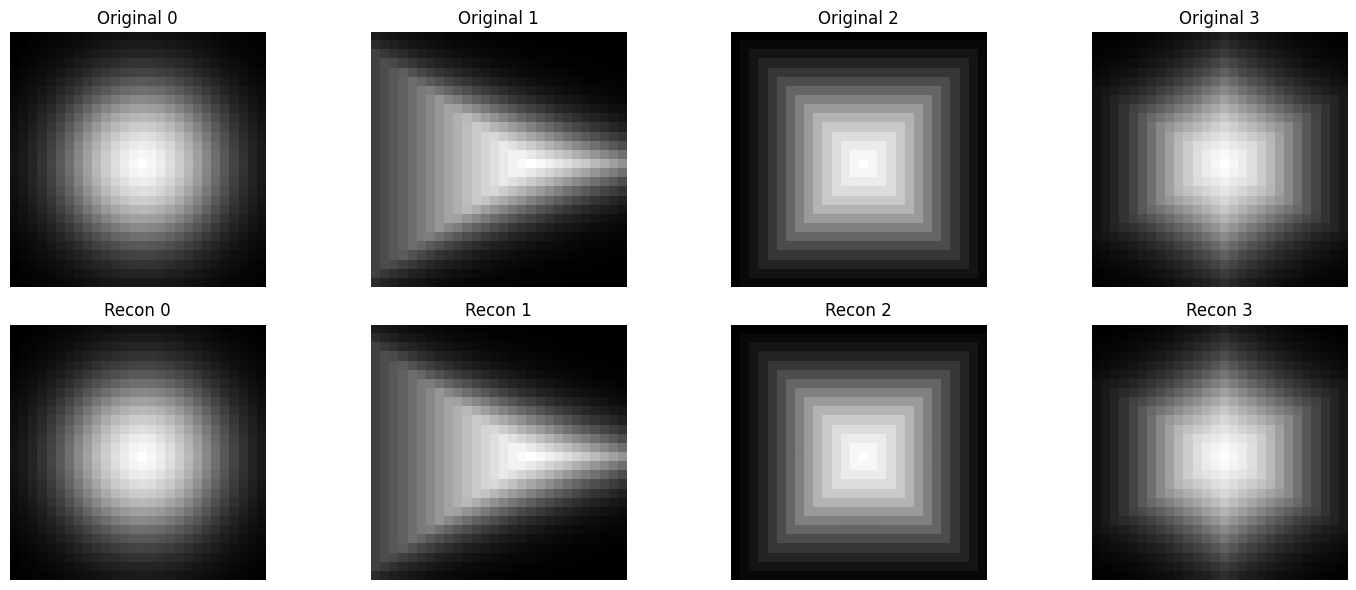

Epoch 6000/10000, Loss: 0.000000


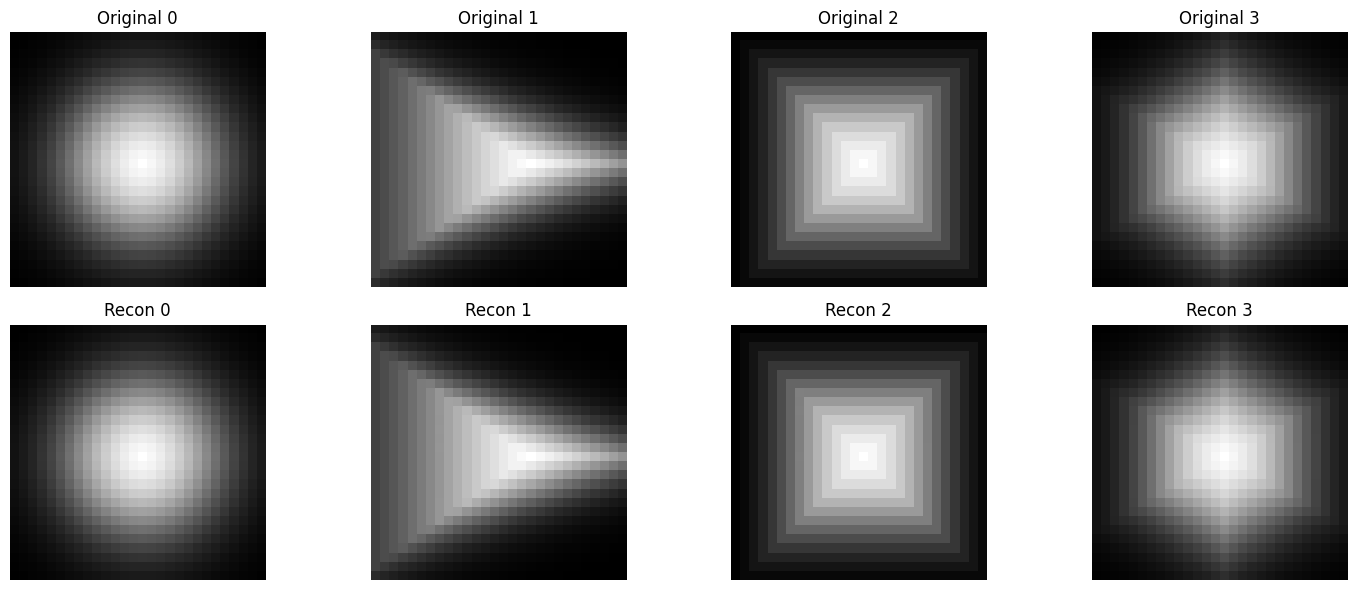

Epoch 7000/10000, Loss: 0.000000


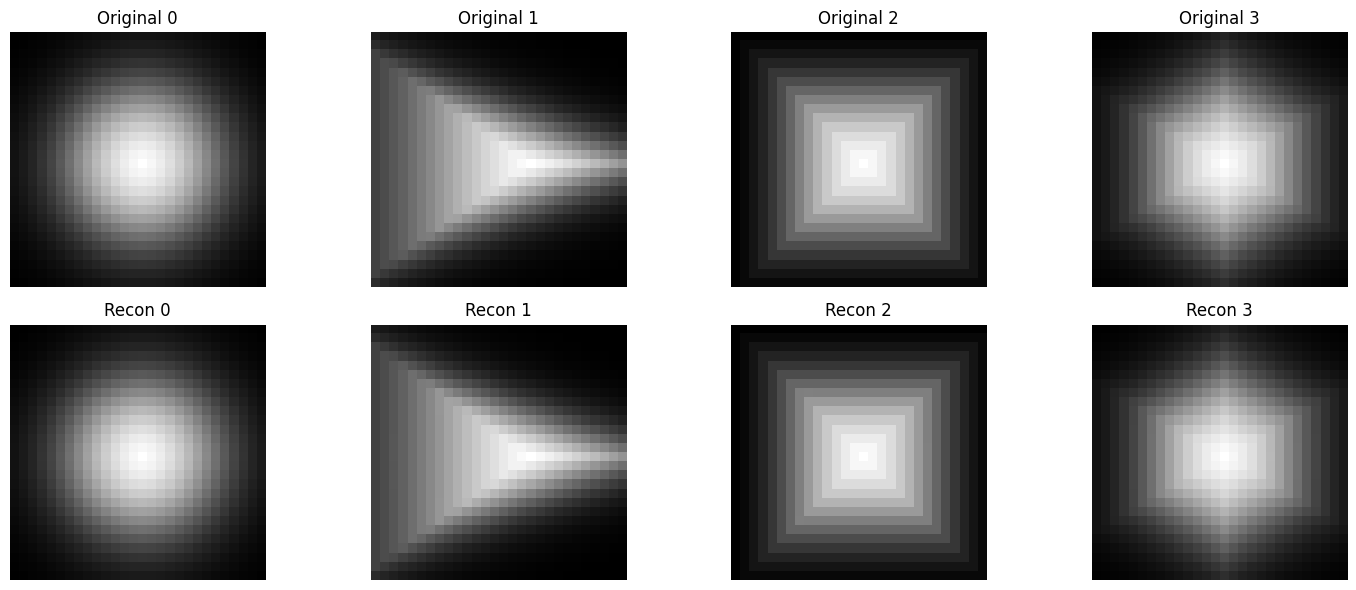

Epoch 8000/10000, Loss: 0.000002


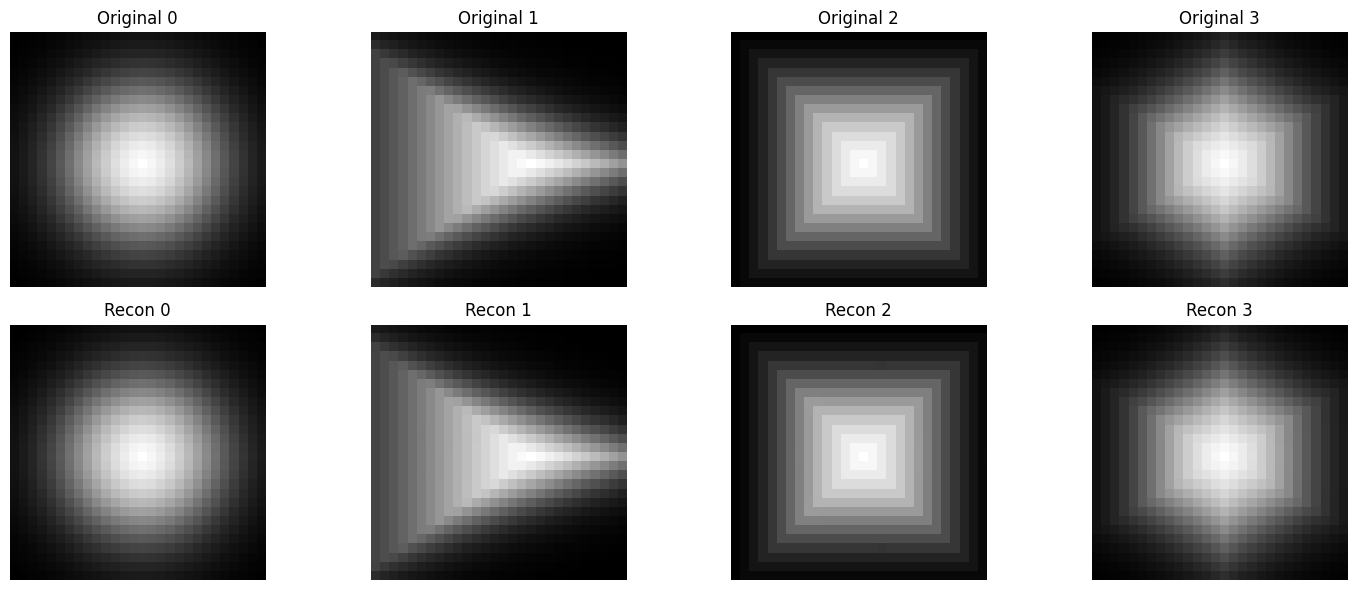

Epoch 9000/10000, Loss: 0.000000


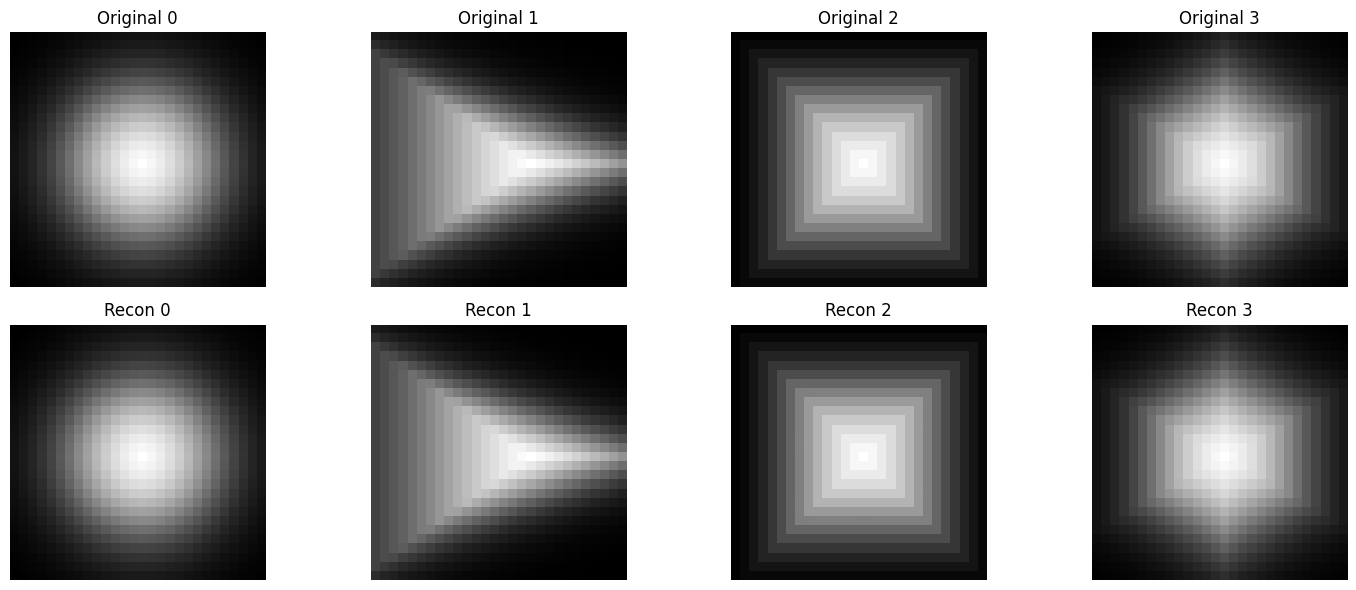

Epoch 10000/10000, Loss: 0.000001


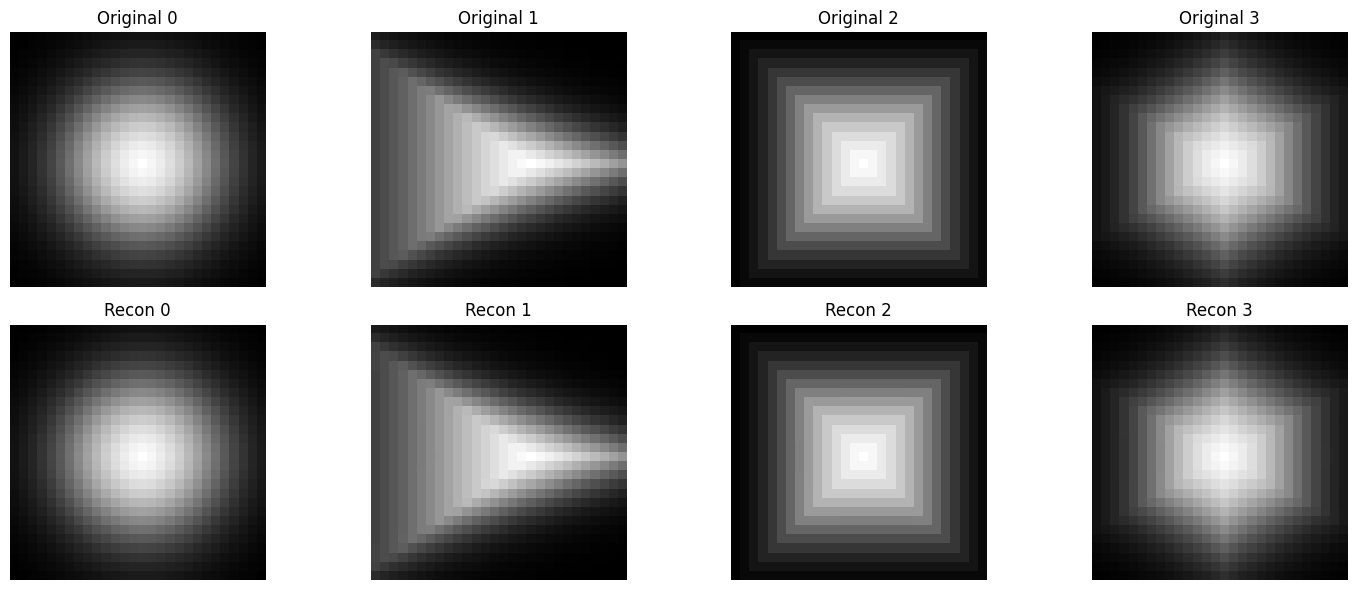

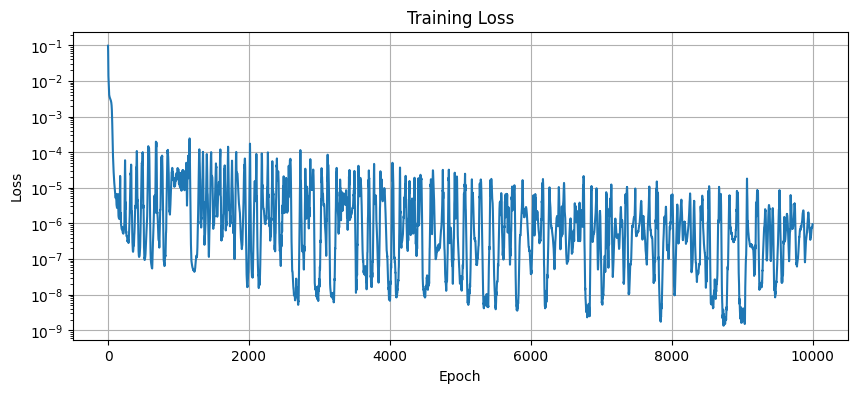

In [4]:
# Create learnable latent codes for each shape
# Initialize them randomly (will be optimized during training)
latent_codes = tf.Variable(
    tf.random.normal([NUM_SHAPES, LATENT_DIM]),
    trainable=True,
    name="latent_codes"
)

# Create optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Define loss function
loss_fn = keras.losses.MeanSquaredError()

# Training parameters
epochs = 10000
display_interval = 1000

# Training loop
@tf.function
def train_step(latent_idx, target_image):
    """Single training step for one shape"""
    with tf.GradientTape() as tape:
        # Get latent code for this shape
        z = tf.gather(latent_codes, latent_idx)
        
        # Decode to get the reconstructed image
        reconstructed = decoder(z)
        
        # Compute loss
        loss = loss_fn(target_image, reconstructed)
    
    # Compute gradients
    trainable_vars = [latent_codes] + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    return loss

# Training history
loss_history = []

# Main training loop
for epoch in range(1, epochs + 1):
    epoch_loss = 0
    
    # Train on each shape
    for i in range(NUM_SHAPES):
        loss = train_step([i], x_data_flat[i:i+1])
        epoch_loss += loss
    
    epoch_loss /= NUM_SHAPES
    loss_history.append(epoch_loss.numpy())
    
    # Display progress
    if epoch % display_interval == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.6f}")

        # Visualize current reconstructions
        plt.figure(figsize=(15, 6))
        
        # Original shapes
        for i in range(NUM_SHAPES):
            plt.subplot(2, NUM_SHAPES, i+1)
            plt.imshow(x_data[i], cmap='gray')
            plt.title(f"Original {i}")
            plt.axis('off')
        
        # Reconstructed shapes
        for i in range(NUM_SHAPES):
            z = tf.gather(latent_codes, [i])
            reconstructed = decoder(z).numpy().reshape(28, 28)
            plt.subplot(2, NUM_SHAPES, NUM_SHAPES+i+1)
            plt.imshow(reconstructed, cmap='gray')
            plt.title(f"Recon {i}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Plot loss history
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

## Visualize Latent Space

Let's visualize where our shapes are located in the latent space.

Learned latent codes:
Shape 0 (class 0): [ 0.4152192 -0.6540073]
Shape 1 (class 1): [ 0.07341606 -1.4253092 ]
Shape 2 (class 2): [-2.2906811 -0.8304257]
Shape 3 (class 3): [-0.43980137  0.45854473]


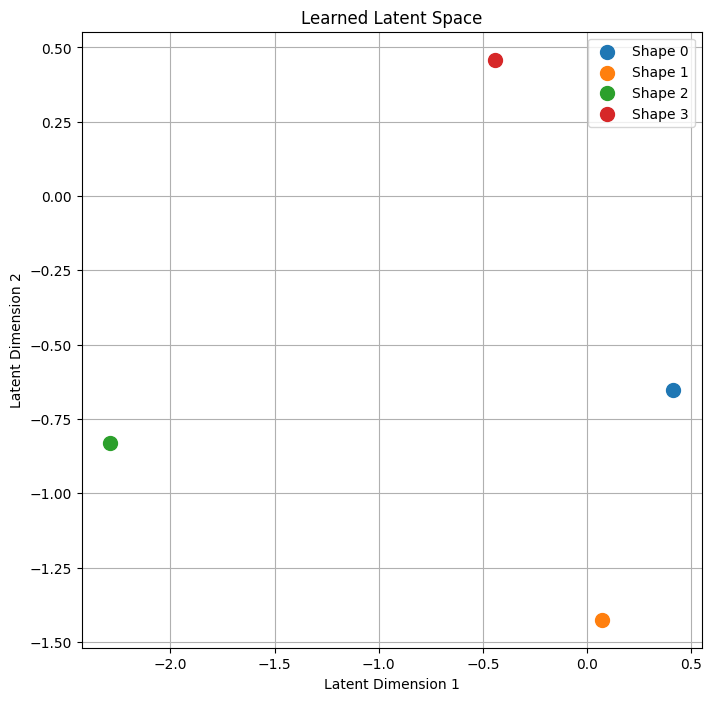

In [5]:
# Get the optimized latent codes
learned_latent_codes = latent_codes.numpy()
print("Learned latent codes:")
for i, code in enumerate(learned_latent_codes):
    print(f"Shape {i} (class {y_data[i]}): {code}")

# Plot latent space
plt.figure(figsize=(8, 8))
for i, code in enumerate(learned_latent_codes):
    plt.scatter(code[0], code[1], s=100, label=f"Shape {y_data[i]}")

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.legend()
plt.title('Learned Latent Space')
plt.show()

## Sample from Latent Space

Let's sample points from the latent space to see what the decoder generates.

1/1 [==============================] - 0s 19ms/step


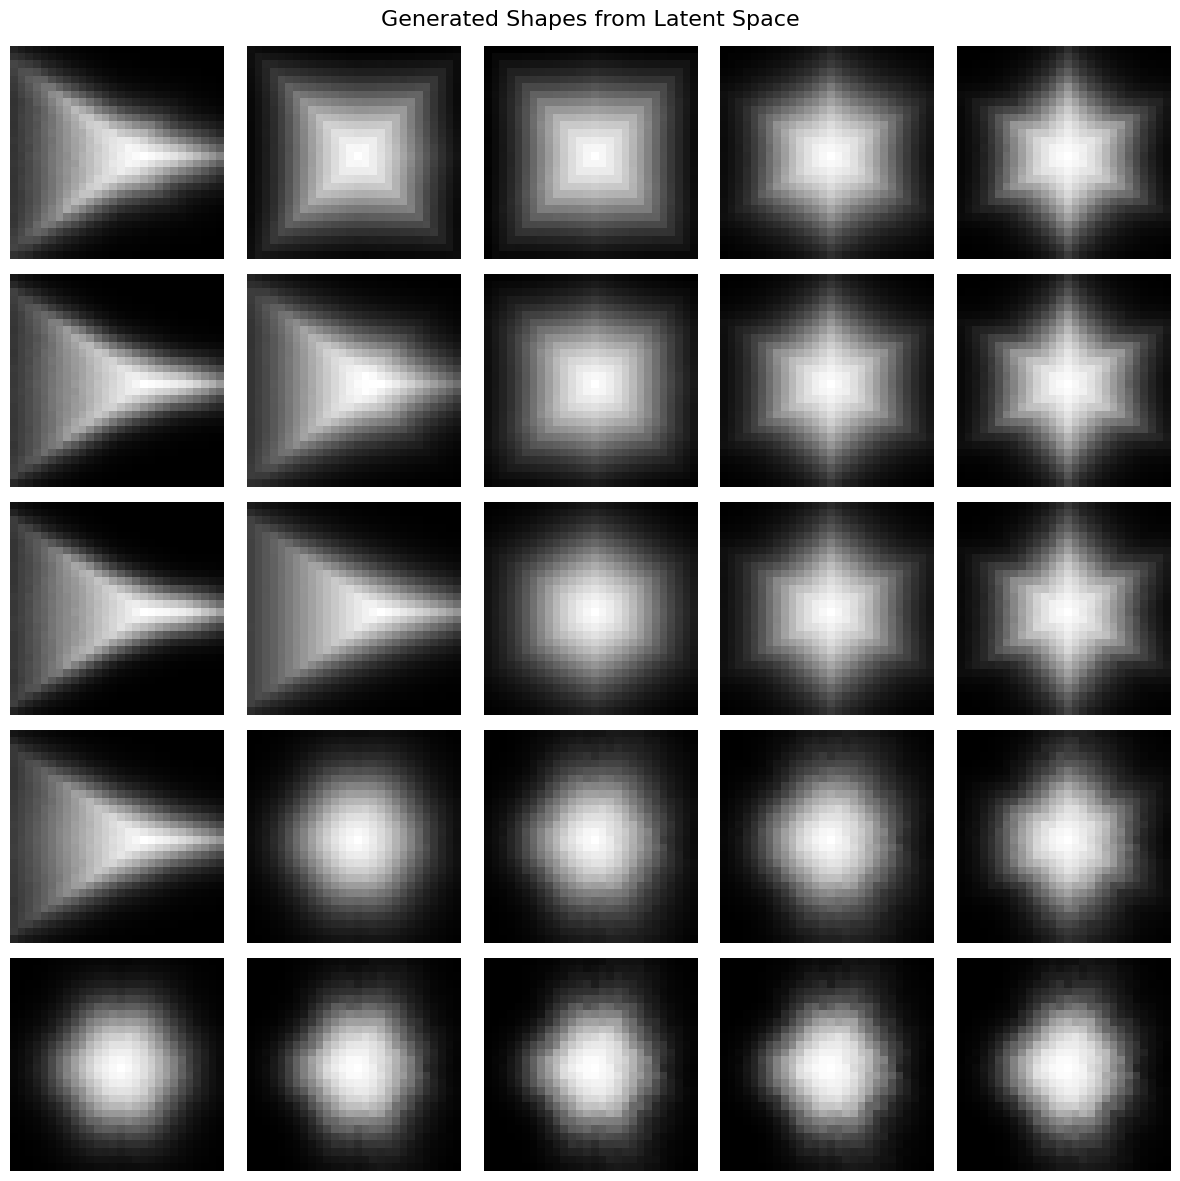

In [6]:
# Create a grid of points in latent space
grid_size = 5
x_range = np.linspace(-3, 3, grid_size)
y_range = np.linspace(-3, 3, grid_size)

plt.figure(figsize=(12, 12))
for i, x_val in enumerate(x_range):
    for j, y_val in enumerate(y_range):
        # Create latent code
        z = np.array([[x_val, y_val]])
        
        # Generate image from latent code
        img = decoder.predict(z).reshape(28, 28)
        
        # Plot
        ax = plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.suptitle('Generated Shapes from Latent Space', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Export Model for TensorflowJS

Now we'll export the decoder model for use in the web application.

In [7]:
import tensorflowjs as tfjs

# Create a fresh model for export
export_model = create_decoder()

# Compile the model (required for saving)
export_model.compile(optimizer='adam', loss='mse')

# Copy weights from trained decoder
export_model.set_weights(decoder.get_weights())

# Create export directory
export_dir = '../public/models/generatorjs'
os.makedirs(export_dir, exist_ok=True)

# Save model directly as TensorFlow.js format
tfjs.converters.save_keras_model(export_model, export_dir)

print(f"Model exported to {export_dir}")
print("Model files:")
for file in os.listdir(export_dir):
    print(f"  - {file}")

Model exported to ../public/models/generatorjs
Model files:
  - group1-shard10of22.bin
  - group1-shard11of22.bin
  - group1-shard12of22.bin
  - group1-shard13of22.bin
  - group1-shard14of22.bin
  - group1-shard15of22.bin
  - group1-shard16of22.bin
  - group1-shard17of22.bin
  - group1-shard18of22.bin
  - group1-shard19of22.bin
  - group1-shard1of1
  - group1-shard1of1.bin
  - group1-shard1of2.bin
  - group1-shard1of22.bin
  - group1-shard20of22.bin
  - group1-shard21of22.bin
  - group1-shard22of22.bin
  - group1-shard2of2.bin
  - group1-shard2of22.bin
  - group1-shard3of22.bin
  - group1-shard4of22.bin
  - group1-shard5of22.bin
  - group1-shard6of22.bin
  - group1-shard7of22.bin
  - group1-shard8of22.bin
  - group1-shard9of22.bin
  - group2-shard1of1
  - group3-shard1of1
  - group4-shard1of1
  - group5-shard1of1
  - group6-shard1of1
  - group7-shard1of1
  - group8-shard10of14
  - group8-shard11of14
  - group8-shard12of14
  - group8-shard13of14
  - group8-shard14of14
  - group8-shard1o

In [8]:
# Generate encoded latent points for visualization
# We'll create a grid of points in latent space, along with their shape class
grid_size = 20
x_min, x_max = -3, 3
y_min, y_max = -3, 3

x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)

encoded_points = []

# For each point in the grid, find which shape it's closest to
for x in x_grid:
    for y in y_grid:
        point = np.array([x, y])
        
        # Generate the image at this latent point
        img = decoder.predict(np.array([point])).reshape(28, 28)
        
        # Find closest shape by reconstructing all shapes and comparing
        min_dist = float('inf')
        closest_shape = 0
        
        for i in range(NUM_SHAPES):
            shape_img = x_data[i]
            # Simple L2 distance
            dist = np.sum((img - shape_img)**2)
            
            if dist < min_dist:
                min_dist = dist
                closest_shape = y_data[i]
        
        # Store [x, y, class]
        encoded_points.append([float(x), float(y), int(closest_shape)])

# Save encoded points to JSON file
with open('../src/encoded.json', 'w') as f:
    json.dump(encoded_points, f)

print(f"Saved {len(encoded_points)} encoded points to encoded.json")

1/1 [==============================] - 0s 24ms/step
Saved 400 encoded points to encoded.json
Saved 400 encoded points to encoded.json


## Model Testing

Test the exported model to ensure it works correctly.

1/1 [==============================] - 0s 20ms/step


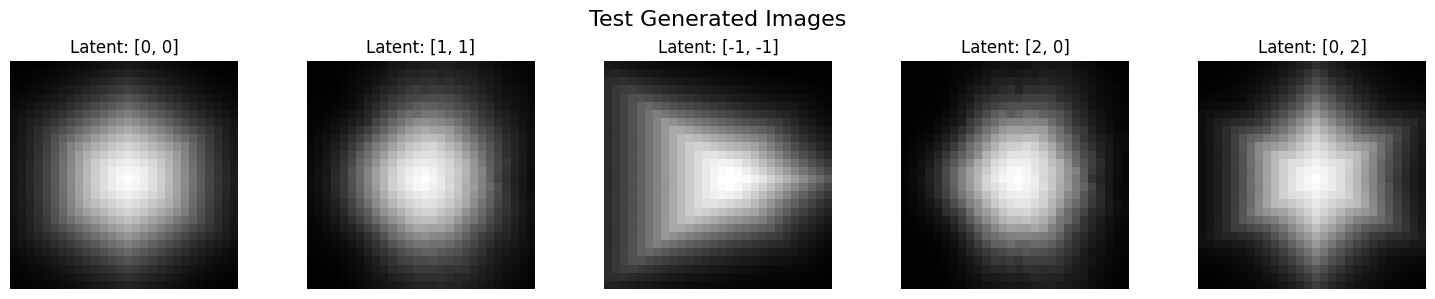

In [9]:
# Test the model with a few latent vectors
test_latents = [
    [0, 0],
    [1, 1],
    [-1, -1],
    [2, 0],
    [0, 2]
]

plt.figure(figsize=(15, 3))
for i, latent in enumerate(test_latents):
    # Generate image from latent code
    img = export_model.predict(np.array([latent])).reshape(28, 28)
    
    # Plot
    plt.subplot(1, len(test_latents), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Latent: {latent}")
    plt.axis('off')

plt.suptitle('Test Generated Images', fontsize=16)
plt.tight_layout()
plt.show()